In [2]:
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns


In [3]:
metadata_path = r"C:\Users\admin\Desktop\AC II\UrbanSound8K\metadata\UrbanSound8K.csv"
metadata = pd.read_csv(metadata_path)
print(metadata.head())


      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


In [ ]:
'''
# Parâmetros
SAMPLE_RATE = 22050
DURATION = 4  # em segundos
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

# Caminho para o dataset
input_path = r"C:\Users\admin\Desktop\AC II\UrbanSound8K\audio"
metadata_path = r"C:\Users\admin\Desktop\AC II\UrbanSound8K\metadata\UrbanSound8K.csv"
output_base_path = r"C:\Users\admin\Desktop\AC II\ProcessedAudio"

# Carregar o arquivo de metadados
metadata = pd.read_csv(metadata_path)

# Função para padronizar o áudio (padding ou repeat)
def preprocess_audio(file_path, method="padding", sample_rate=SAMPLE_RATE, duration=DURATION):
    try:
        # Carregar o áudio
        signal, sr = librosa.load(file_path, sr=sample_rate)
        target_length = sample_rate * duration

        # Ajustar o tamanho do sinal
        if len(signal) < target_length:
            if method == "padding":
                # Adicionar zeros
                signal = np.pad(signal, (0, target_length - len(signal)), 'constant')
            elif method == "repeat":
                # Repetir o som
                repeat_count = target_length // len(signal) + 1
                signal = np.tile(signal, repeat_count)[:target_length]
        else:
            # Truncar o sinal longo
            signal = signal[:target_length]

        return signal
    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")
        return None

# Criar as pastas de saída (padding e repeat)
os.makedirs(os.path.join(output_base_path, "padding"), exist_ok=True)
os.makedirs(os.path.join(output_base_path, "repeat"), exist_ok=True)

for folder in range(1, 11):  # UrbanSound8K possui folders de 1 a 10
    os.makedirs(os.path.join(output_base_path, "padding", f"fold{folder}"), exist_ok=True)
    os.makedirs(os.path.join(output_base_path, "repeat", f"fold{folder}"), exist_ok=True)

# Adicionar o caminho completo dos arquivos ao dataframe
metadata['file_path'] = metadata.apply(
    lambda row: os.path.join(input_path, f"fold{row['fold']}", row['slice_file_name']), axis=1
)

# Processar e salvar os áudios
for index, row in metadata.iterrows():
    file_path = row['file_path']
    fold = row['fold']
    file_name = row['slice_file_name']
    
    # Processar com padding
    signal_padding = preprocess_audio(file_path, method="padding")
    if signal_padding is not None:
        output_folder_padding = os.path.join(output_base_path, "padding", f"fold{fold}")
        np.save(os.path.join(output_folder_padding, file_name.replace('.wav', '.npy')), signal_padding)

    # Processar com repeat
    signal_repeat = preprocess_audio(file_path, method="repeat")
    if signal_repeat is not None:
        output_folder_repeat = os.path.join(output_base_path, "repeat", f"fold{fold}")
        np.save(os.path.join(output_folder_repeat, file_name.replace('.wav', '.npy')), signal_repeat)

print("Processamento concluído e dados salvos!")
'''

Processamento concluído e dados salvos!


In [ ]:
'''
def extract_mel_spectrogram(signal, sample_rate=22050, n_mels=128):
    """
    Extrai o espectrograma de Mel do sinal de áudio.
    """
    S = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=n_mels)
    return librosa.power_to_db(S).T  # Converte para dB e transpõe

# Ainda nao extrai o espetograma, mas é util para o CNN 2D. Para isso basta substituir la em baixo a funçao e tambem os arquivos

def extract_mfcc(signal, sample_rate=22050, n_mfcc=13):
    """
    Extrai os MFCCs do sinal de áudio.
    """
    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc)
    return mfccs.T  # Transpor para ter (tempo x coeficientes)

# Caminho para os sinais processados (ex.: padding)
processed_data_path = r"C:\Users\admin\Desktop\AC II\ProcessedAudio\repeat"

# Caminho para salvar os MFCCs
output_mfcc_path = r"C:\Users\admin\Desktop\AC II\MFCCs\repeat"
os.makedirs(output_mfcc_path, exist_ok=True)

# Loop pelos folds
for fold in range(1, 11):
    input_folder = os.path.join(processed_data_path, f"fold{fold}")
    output_folder = os.path.join(output_mfcc_path, f"fold{fold}")
    os.makedirs(output_folder, exist_ok=True)

    for file in os.listdir(input_folder):
        if file.endswith(".npy"):
            # Carregar o sinal
            signal = np.load(os.path.join(input_folder, file))
            
            # Extrair MFCCs
            mfcc = extract_mfcc(signal)
            
            # Salvar os MFCCs como numpy array
            np.save(os.path.join(output_folder, file), mfcc)

print("Extração de MFCCs concluída!")
'''

Extração de MFCCs concluída!


## Aqui começa a parte do MLP, onde os valores são achatados para ficarem em uma dimensão

In [7]:
def load_mfccs_by_fold(folder_path):
    """
    Carrega os MFCCs organizados por fold.
    """
    X_folds = []  # Lista de arrays X para cada fold
    y_folds = []  # Lista de arrays y para cada fold

    for fold in range(1, 11):  # UrbanSound8K tem 10 folds
        fold_path = os.path.join(folder_path, f"fold{fold}")
        X_fold = []
        y_fold = []

        for file in os.listdir(fold_path):
            if file.endswith(".npy"):
                # Carregar o MFCC
                mfcc = np.load(os.path.join(fold_path, file))

                # Achatar o MFCC
                flattened = mfcc.flatten()
                X_fold.append(flattened)

                # Associar o rótulo
                label = int(file.split("-")[1])  # Exemplo: "7061-6-0-0.npy" -> classe 6
                y_fold.append(label)

        X_folds.append(np.array(X_fold))
        y_folds.append(np.array(y_fold))

    return X_folds, y_folds

# Caminho para os MFCCs processados
mfcc_folder_path = r"C:\Users\admin\Desktop\AC II\MFCCs\padding"
X_folds, y_folds = load_mfccs_by_fold(mfcc_folder_path)

print(f"Número de folds: {len(X_folds)}")
print(f"Tamanho do Fold 1: {X_folds[0].shape}, {y_folds[0].shape}")


Número de folds: 10
Tamanho do Fold 1: (873, 2249), (873,)


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Transformar os rótulos para one-hot encoding
y = to_categorical(y, num_classes=10)

# Criar o modelo
model = Sequential([
    Dense(512, activation='relu', input_shape=(X.shape[1],)),  # Primeira camada oculta
    Dropout(0.3),  # Dropout para evitar overfitting
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')  # Camada de saída (10 classes)
])

# Compilar o modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               1152000   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 10)               

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

for test_fold_idx in range(10):  # 10 folds no UrbanSound8K
    # Teste: O fold atual
    X_test = X_folds[test_fold_idx]
    y_test = y_folds[test_fold_idx]

    # Treino + Validação: Os demais folds
    X_train_val = np.concatenate([X_folds[i] for i in range(10) if i != test_fold_idx], axis=0)
    y_train_val = np.concatenate([y_folds[i] for i in range(10) if i != test_fold_idx], axis=0)

    # Normalizar os dados
    scaler = StandardScaler()
    X_train_val = scaler.fit_transform(X_train_val)
    X_test = scaler.transform(X_test)

    # Divisão treino/validação
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

    print(f"Iteração {test_fold_idx + 1}:")
    print(f"Treino: {X_train.shape}, Validação: {X_val.shape}, Teste: {X_test.shape}")


Iteração 1:
Treino: (6287, 2249), Validação: (1572, 2249), Teste: (873, 2249)
Iteração 2:
Treino: (6275, 2249), Validação: (1569, 2249), Teste: (888, 2249)
Iteração 3:
Treino: (6245, 2249), Validação: (1562, 2249), Teste: (925, 2249)
Iteração 4:
Treino: (6193, 2249), Validação: (1549, 2249), Teste: (990, 2249)
Iteração 5:
Treino: (6236, 2249), Validação: (1560, 2249), Teste: (936, 2249)
Iteração 6:
Treino: (6327, 2249), Validação: (1582, 2249), Teste: (823, 2249)
Iteração 7:
Treino: (6315, 2249), Validação: (1579, 2249), Teste: (838, 2249)
Iteração 8:
Treino: (6340, 2249), Validação: (1586, 2249), Teste: (806, 2249)
Iteração 9:
Treino: (6332, 2249), Validação: (1584, 2249), Teste: (816, 2249)
Iteração 10:
Treino: (6316, 2249), Validação: (1579, 2249), Teste: (837, 2249)


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import numpy as np

# Parâmetros
num_classes = 10
epochs = 50
batch_size = 32

# Resultados por fold
fold_accuracies = []
fold_losses = []

for test_fold_idx in range(10):  # 10 folds no UrbanSound8K
    # Teste: O fold atual
    X_test = X_folds[test_fold_idx]
    y_test = y_folds[test_fold_idx]

    # Treino + Validação: Os demais folds
    X_train_val = np.concatenate([X_folds[i] for i in range(10) if i != test_fold_idx], axis=0)
    y_train_val = np.concatenate([y_folds[i] for i in range(10) if i != test_fold_idx], axis=0)

    # Normalizar os dados
    scaler = StandardScaler()
    X_train_val = scaler.fit_transform(X_train_val)
    X_test = scaler.transform(X_test)

    # Divisão treino/validação
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

    # Transformar rótulos em one-hot encoding
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_val = to_categorical(y_val, num_classes=num_classes)
    y_test = to_categorical(y_test, num_classes=num_classes)

    # Criar o modelo
    model = Sequential([
        Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    # Compilar o modelo
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Treinar o modelo
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1
    )

    # Avaliar no conjunto de teste
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    fold_accuracies.append(test_accuracy)
    fold_losses.append(test_loss)

    print(f"Fold {test_fold_idx + 1}: Test Loss = {test_loss:.4f}, Test Accuracy = {test_accuracy:.4f}")

# Resultados finais
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

print(f"\nResultados Finais:")
print(f"Acurácia Média: {mean_accuracy * 100:.2f}%")
print(f"Desvio Padrão da Acurácia: {std_accuracy * 100:.2f}%")


Epoch 1/50
197/197 [==============================] - 3s 10ms/step - loss: 1.8396 - accuracy: 0.4002 - val_loss: 1.2456 - val_accuracy: 0.5941
Epoch 2/50
197/197 [==============================] - 2s 10ms/step - loss: 1.4108 - accuracy: 0.5233 - val_loss: 1.0761 - val_accuracy: 0.6330
Epoch 3/50
197/197 [==============================] - 2s 10ms/step - loss: 1.2685 - accuracy: 0.5680 - val_loss: 0.9598 - val_accuracy: 0.6781
Epoch 4/50
197/197 [==============================] - 2s 10ms/step - loss: 1.1486 - accuracy: 0.6087 - val_loss: 0.8858 - val_accuracy: 0.7010
Epoch 5/50
197/197 [==============================] - 2s 11ms/step - loss: 1.0190 - accuracy: 0.6480 - val_loss: 0.7990 - val_accuracy: 0.7494
Epoch 6/50
197/197 [==============================] - 2s 11ms/step - loss: 0.9701 - accuracy: 0.6730 - val_loss: 0.8123 - val_accuracy: 0.7436
Epoch 7/50
197/197 [==============================] - 2s 12ms/step - loss: 0.9028 - accuracy: 0.6868 - val_loss: 0.7345 - val_accuracy: 0.7354

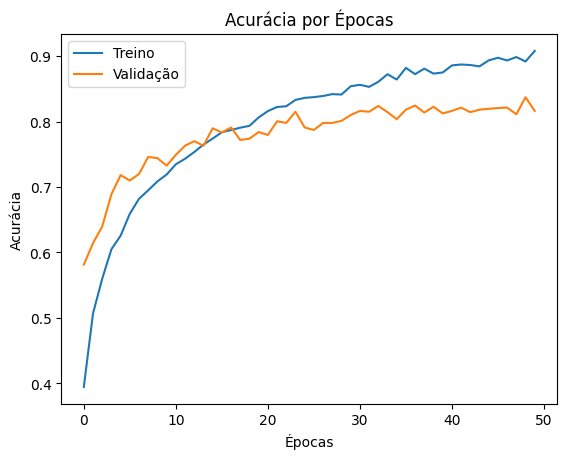

In [12]:
import matplotlib.pyplot as plt

# Exemplo para o último fold (pode iterar por todos os folds, se necessário)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia por Épocas')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()


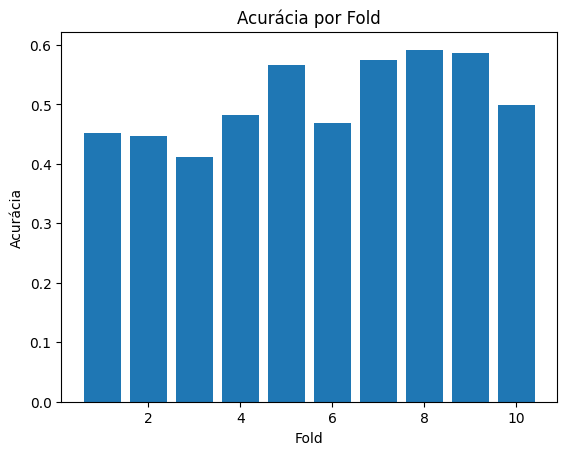

In [13]:
# Gráfico de Acurácia por Fold
plt.bar(range(1, 11), fold_accuracies)
plt.title('Acurácia por Fold')
plt.xlabel('Fold')
plt.ylabel('Acurácia')
plt.show()
